In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.formula.api import ols
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dendykurniariagman/mamikos-jabodetabek-boarding-room-listings")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\rafli\.cache\kagglehub\datasets\dendykurniariagman\mamikos-jabodetabek-boarding-room-listings\versions\1


In [3]:
df = pd.read_excel(r"C:\Users\rafli\.cache\kagglehub\datasets\dendykurniariagman\mamikos-jabodetabek-boarding-room-listings\versions\1\Mamikos Jabodetabek Data.xlsx")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2485 entries, 0 to 2484
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   room_name                 2485 non-null   object
 1   owner_name                2485 non-null   object
 2   region                    2485 non-null   object
 3   location                  2485 non-null   object
 4   room_size                 2459 non-null   object
 5   is_electricity_included   2462 non-null   object
 6   price_before_discount_bs  641 non-null    object
 7   all_facilities_bs         2464 non-null   object
 8   room_availability_bs      2049 non-null   object
 9   deposit_amount_bs         1690 non-null   object
 10  price                     2485 non-null   object
 11  rating                    2485 non-null   object
 12  rating_count              2485 non-null   object
 13  transaction_count         2485 non-null   object
 14  tipe_kos                

In [5]:
df.shape

(2485, 17)

In [6]:
df.describe()

,room_name,owner_name,region,location,room_size,is_electricity_included,price_before_discount_bs,all_facilities_bs,room_availability_bs,deposit_amount_bs,price,rating,rating_count,transaction_count,tipe_kos,discount_amount,url
count,2485,2485,2485,2485,2459,2462,641,2464,2049,1690,2485,2485,2485,2485,2485,2485,2485
unique,2311,948,10,207,355,2,163,2258,6,77,489,27,79,124,3,157,2311
top,Kost Ruma Cemara VVIP Cikarang Selatan Bekasi,Kos dikelola oleh Dida,Bekasi,Cikarang Selatan,3 x 3 meter,Tidak termasuk listrik,Rp1.825.000,3.5 x 5 meter; Tidak termasuk listrik; AC; Kas...,Tersisa1 kamar,Rp300.000,Rp1.500.000,Not found,Not found,Not found,Kos Campur,Not found,https://mamikos.com/room/kost-kabupaten-bekasi...
freq,10,414,315,131,571,1928,36,8,616,460,113,733,1362,923,1409,1347,10


## Data Cleaning

In [7]:
not_found_col = ['rating', 'rating_count', 'transaction_count', 'discount_amount']

for col in not_found_col:
    print(f'\ndata unik di {col} yang banyak not found')
    print(df[col].unique())



data unik di rating yang banyak not found
['Not found' '1.0' '4.8' '5.0' '4.1' '4.0' '4.6' '3.6' '4.9' '3.4' '4.5'
 '3.8' '4.4' '4.3' '3.5' '3.1' '2.5' '3.9' '1.9' '2.9' '2.1' '2.0' '1.5'
 '1.3' '3.0' '3.3' '1.4']

data unik di rating_count yang banyak not found
['Not found' '(5)' '(1)' '(31)' '(4)' '(11)' '(7)' '(21)' '(9)' '(6)'
 '(13)' '(8)' '(32)' '(0)' '(3)' '(40)' '(2)' '(65)' '(30)' '(22)' '(51)'
 '(35)' '(12)' '(16)' '(15)' '(19)' '(14)' '(45)' '(25)' '(10)' '(27)'
 '(18)' '(17)' '(23)' '(28)' '(46)' '(42)' '(20)' '(24)' '(50)' '(48)'
 '(39)' '(59)' '(33)' '(47)' '(29)' '(72)' '(26)' '(60)' '(103)' '(71)'
 '(68)' '(36)' '(66)' '(142)' '(58)' '(74)' '(43)' '(49)' '(93)' '(104)'
 '(86)' '(62)' '(34)' '(106)' '(57)' '(73)' '(126)' '(37)' '(61)' '(54)'
 '(63)' '(38)' '(70)' '(102)' '(117)' '(83)' '(109)' '(44)']

data unik di transaction_count yang banyak not found
['Not found' '22 transaksi berhasil di kos ini'
 '13 transaksi berhasil di kos ini' '12 transaksi berhasil di kos ini

In [8]:
df['room_availability_bs'].unique()

array([nan, 'Kamar penuh', 'Tersisa1 kamar', 'Tersisa2 kamar',
       'Kamar penuh,lihat kos lainnya',
       'Kamar penuh,lihat tipe kamar lainnya', 'Tersisa3 kamar'],
      dtype=object)

In [9]:
#fill kolom price
df['price'] = pd.to_numeric(df['price'].str.replace('Rp','',regex=False)\
                    .str.replace('.','',regex=False))
#fill kolom discount
df['discount_amount'] = df['discount_amount'].replace('Not found', 0)\
                        .str.extract(r'(\d+)')\
                        .astype(float).fillna(0) * 1000
#price before discount
df['price_before_discount_bs'] = df['price'] + df['discount_amount']
#fill kolom rating
df['rating'] = df['rating'].replace('Not found', 0).astype(float).fillna(0)
#fill kolom rating_count
df['rating_count'] = df['rating_count'].replace('Not found', 0)\
                     .str.replace(r'[()]', '', regex=True)\
                     .astype(float).fillna(0)
#konsistensi rating (kalau rating_count = 0 maka rating = 0)
df.loc[df['rating_count'] == 0, 'rating'] = 0
#fill kolom transaction_count
df['transaction_count'] = df['transaction_count'].replace('Not found', 0)\
                          .str.extract(r'(\d+)')\
                          .astype(float).fillna(0)
#hitung room_area
df[['length', 'width']] = df['room_size'].str.extract(r'([\d\.]+)\s*x\s*([\d\.]+)').astype(float)
df['room_area'] = df['length'] * df['width']
#buat kolom is_discount
df['is_discount'] = (df['discount_amount'] > 0).astype(int)
df['room_availability_bs'] = df['room_availability_bs'].map({
    'Kamar penuh': 0,
    'Tersisa1 kamar': 1,
    'Tersisa2 kamar': 2,
    'Kamar penuh,lihat kos lainnya': 0,
    'Kamar penuh,lihat tipe kamar lainnya': 0,
    'Tersisa3 kamar': 3
}).fillna(0)  # kalau NaN jadi 0 juga
#drop kolom yang udah ga kepake
df = df.drop(columns= ['room_name', 'owner_name','is_electricity_included', 'room_size', 'length', 'width', 'price_before_discount_bs', 'discount_amount', 'deposit_amount_bs', 'url'])

df.head()


,region,location,all_facilities_bs,room_availability_bs,price,rating,rating_count,transaction_count,tipe_kos,room_area,is_discount
0,Bogor,Babakan Madang,3 x 4 meter; Termasuk listrik; Kasur; Bantal; ...,0.0,950000,0.0,0.0,0.0,Kos Campur,12.0,0
1,Depok,Cinere,4 x 3 meter; Tidak termasuk listrik; AC; Kasur...,0.0,1100000,0.0,0.0,0.0,Kos Putra,12.0,0
2,Tangerang Selatan,Kecamatan Pondok Aren,3 x 3 meter; Tidak termasuk listrik; AC; Kasur...,1.0,1100000,0.0,0.0,0.0,Kos Putra,9.0,0
3,Bogor,Babakan Madang,3 x 4 meter; Termasuk listrik; Kasur; Lemari B...,2.0,700000,0.0,0.0,0.0,Kos Campur,12.0,0
4,Tangerang Selatan,Kecamatan Serpong Utara,2 x 3 meter; Termasuk listrik; AC; Kasur; Lema...,2.0,1500000,0.0,0.0,0.0,Kos Putra,6.0,0


In [10]:
missing_values = df.isnull().sum()

missing_values = (missing_values[missing_values > 1] / len(df) * 100).round(2)

col_missing_values = missing_values.index.tolist()

missing_values


all_facilities_bs    0.85
room_area            1.05
dtype: float64

In [11]:
#fill missing values
df['all_facilities_bs'] = df['all_facilities_bs'].fillna('unknown')
df['room_area'] = df['room_area'].fillna(df['room_area'].mode().iloc[0])

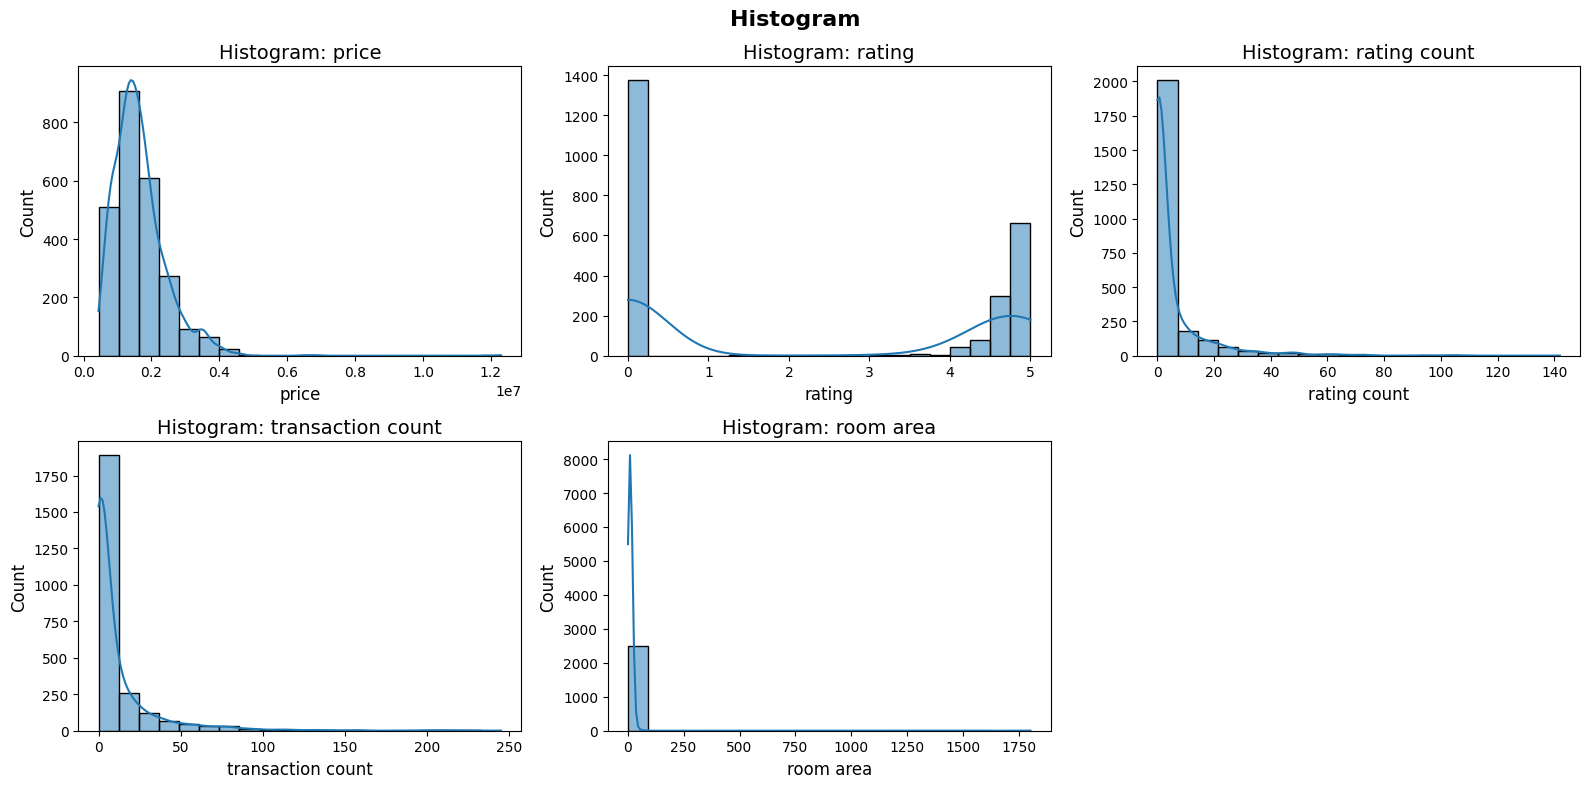

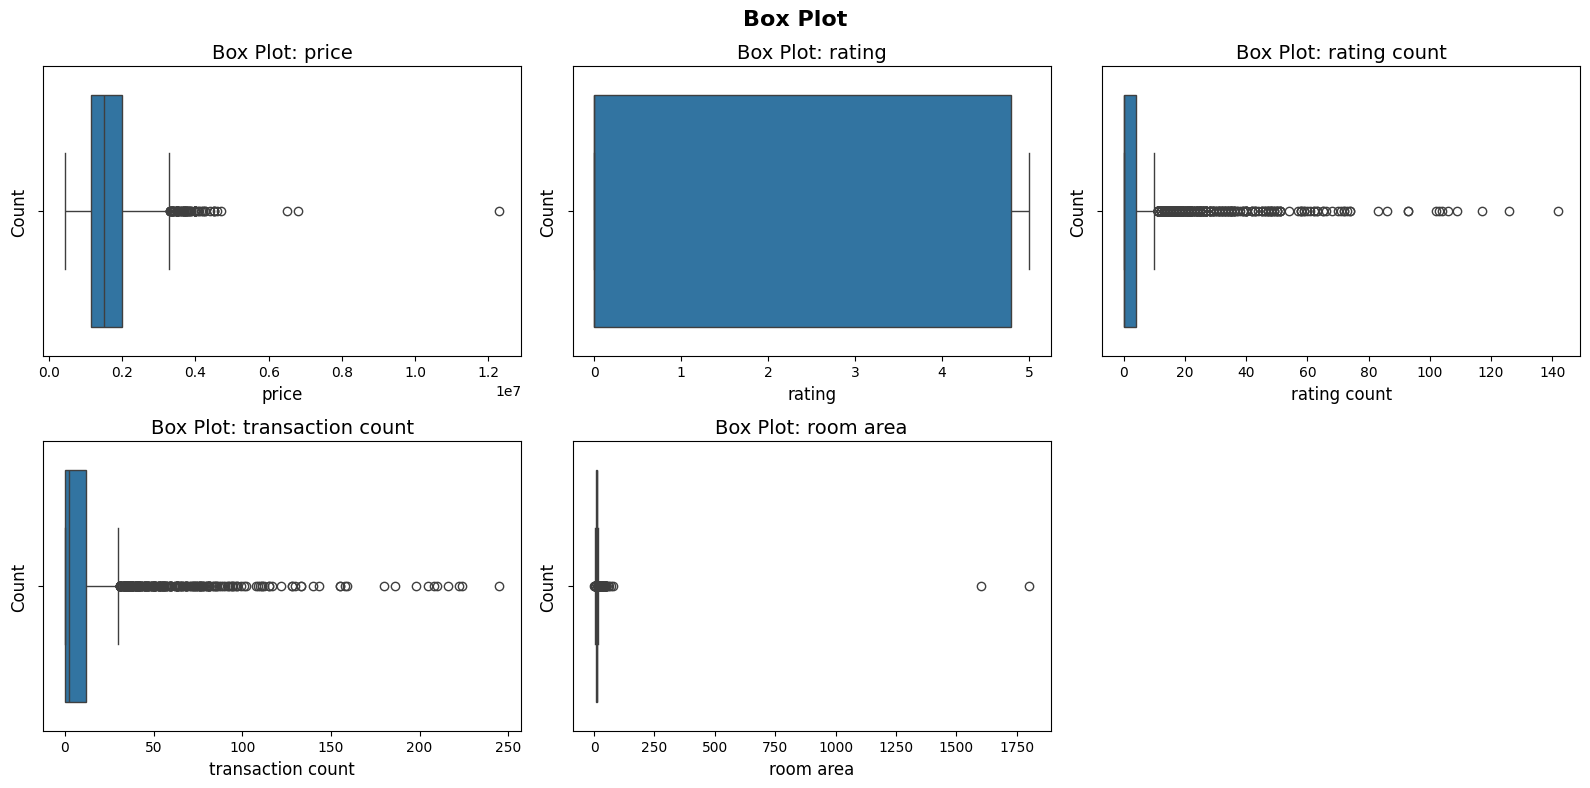

In [12]:
numeric_col = ['price',	'rating', 'rating_count', 'transaction_count', 'room_area']

def create_histogram_boxplot(df, numeric_col):

    plt.figure(figsize=(16,8))

    for i, col in enumerate(numeric_col, 1):
        plt.subplot(2,3,i)

        sns.histplot(data = df,
                     x = col,
                     bins= 20,
                     kde= True)
        
        plt.title(f'Histogram: {col.replace('_', ' ')}', fontsize = 14)
        plt.xlabel(col.replace('_', ' '), fontsize = 12)
        plt.ylabel('Count', fontsize = 12)
        
    plt.suptitle(f'Histogram', fontsize = 16, fontweight = 'bold')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16,8))

    for i, col in enumerate(numeric_col, 1):
        plt.subplot(2,3,i)

        sns.boxplot(data = df,
                     x = col
                     )
        
        plt.title(f'Box Plot: {col.replace('_', ' ')}', fontsize = 14)
        plt.xlabel(col.replace('_', ' '), fontsize = 12)
        plt.ylabel('Count', fontsize = 12)
        
    plt.suptitle(f'Box Plot', fontsize = 16, fontweight = 'bold')
    plt.tight_layout()
    plt.show()

create_histogram_boxplot(df, numeric_col)

terdata data yang aneh (outliers) pada kolom price & room area

In [13]:
df[df['price'] == df['price'].max()]

,region,location,all_facilities_bs,room_availability_bs,price,rating,rating_count,transaction_count,tipe_kos,room_area,is_discount
2469,Tangerang Selatan,Ciputat Timur,4 x 4 meter; Termasuk listrik; Kasur; Meja; Di...,2.0,12300000,0.0,0.0,0.0,Kos Putri,16.0,0


In [14]:
df[df['room_area'] > 100]

,region,location,all_facilities_bs,room_availability_bs,price,rating,rating_count,transaction_count,tipe_kos,room_area,is_discount
409,Bogor,Sukaraja,40 x 40 meter; Tidak termasuk listrik; Jendela...,0.0,900000,0.0,0.0,0.0,Kos Campur,1600.0,0
2476,Bekasi,Kecamatan Serang Baru,30 x 60 meter; Tidak termasuk listrik; Ventila...,1.0,1100000,0.0,0.0,0.0,Kos Campur,1800.0,0


untuk data price yang diatas 10 juta, dan room area diatas 100 M, saya memutuskan untuk menghapus datanya, karena saya anggap data itu adalah outlier

In [15]:
df = df.drop([2469, 409, 2476])

Use Cases:

• Price Benchmarking: Compare kos rental prices across Jabodetabek.

• Location Trends: Spot which regions/subdistricts have higher kos density or price clusters.

• Amenities Analysis: See which facilities (WiFi, AC, furniture) are most common and how they affect price.

• Predictive Modeling: Build machine learning models to estimate kos price.

### Price Benchmarking across JaBoDeTaBek

In [16]:
region_map = {
    'Jakarta Barat': 'Jakarta',
    'Jakarta Utara': 'Jakarta',
    'Jakarta Selatan': 'Jakarta',
    'Jakarta Timur': 'Jakarta',
    'Jakarta Pusat': 'Jakarta',
    'Tangerang Selatan': 'Tangerang',
    'Tangerang': 'Tangerang',
    'Bekasi': 'Bekasi',
    'Depok': 'Depok',
    'Bogor': 'Bogor'
}

df['region_group'] = df['region'].map(region_map)

In [17]:
jabodetabek = (
    df.groupby('region_group', as_index=False)
      .agg({
          'price': ['median', 'mean']
      })
)

# rapihin nama kolom
jabodetabek.columns = ['region_group', 'median_price', 'mean_price']

jabodetabek = jabodetabek.sort_values('median_price', ascending=False).reset_index(drop=True)


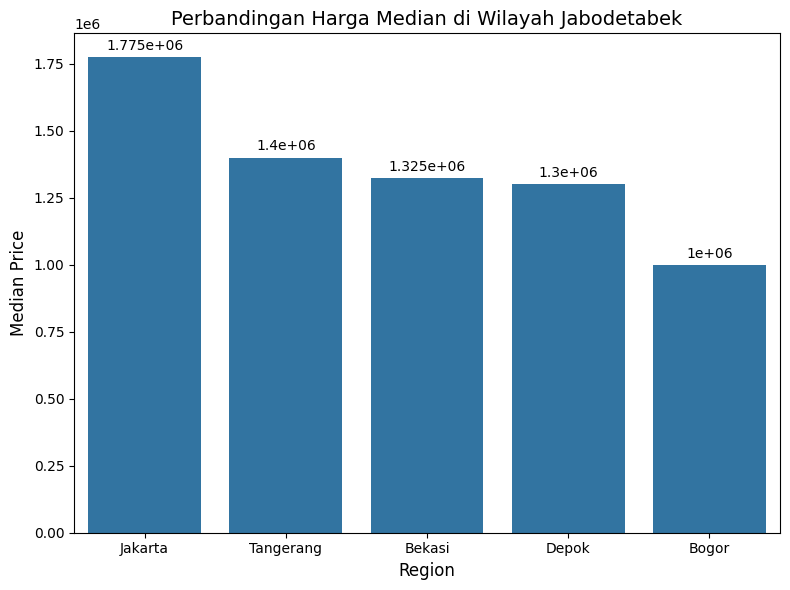

In [18]:
plt.figure(figsize=(8,6))

ax = sns.barplot(data = jabodetabek,
            x = 'region_group',
            y = 'median_price')

plt.title('Perbandingan Harga Median di Wilayah Jabodetabek', fontsize = 14)
plt.xlabel('Region', fontsize = 12)
plt.ylabel('Median Price', fontsize = 12)

for container in ax.containers:
    ax.bar_label(container, label_type= 'edge', padding= 3)

plt.tight_layout()
plt.show()

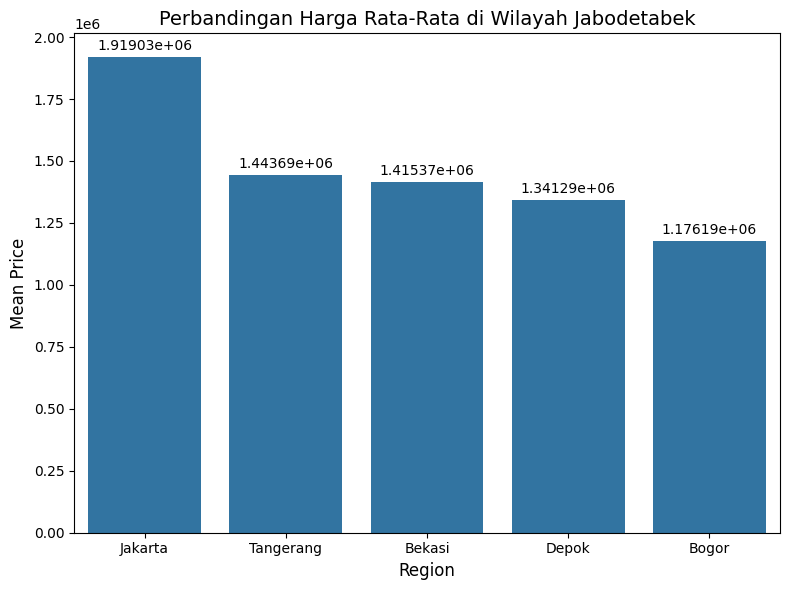

In [19]:
plt.figure(figsize=(8,6))

ax = sns.barplot(data = jabodetabek,
            x = 'region_group',
            y = 'mean_price')

plt.title('Perbandingan Harga Rata-Rata di Wilayah Jabodetabek', fontsize = 14)
plt.xlabel('Region', fontsize = 12)
plt.ylabel('Mean Price', fontsize = 12)

for container in ax.containers:
    ax.bar_label(container, label_type= 'edge', padding= 3)

plt.tight_layout()
plt.show()

- Jakarta memiliki harga kos paling tinggi baik dari sisi median (Rp1,77 juta) maupun mean (Rp1,91 juta). Ini menunjukkan pasar kos di Jakarta cenderung premium, dengan keberadaan kos eksklusif yang mendorong rata-rata harga lebih tinggi.

- Bogor menjadi wilayah dengan harga kos paling rendah, baik median maupun mean (sekitar Rp1 juta–Rp1,17 juta). Hal ini mengindikasikan Bogor lebih cocok sebagai area kos dengan segmen harga terjangkau, kemungkinan besar banyak ditujukan untuk mahasiswa dan pekerja dengan budget terbatas.

- Tangerang, Bekasi, dan Depok berada pada level menengah (Rp1,3–1,4 juta). Ketiga wilayah ini relatif stabil dan dapat dikategorikan sebagai pasar kos kelas menengah.

- Perbedaan signifikan antara median dan mean di Jakarta menunjukkan adanya keberadaan kos dengan harga sangat tinggi (outlier) yang memengaruhi rata-rata, sehingga Jakarta memiliki pasar kos yang lebih beragam dari sisi segmentasi.

### region have higher kos density or price clusters.

In [20]:
density_df = df.groupby('region').agg(
    total_kos=('region', 'size'),
    median_price=('price', 'median')
).reset_index()

density_df

,region,total_kos,median_price
0,Bekasi,314,1325000.0
1,Bogor,233,1000000.0
2,Depok,238,1300000.0
3,Jakarta Barat,231,1957000.0
4,Jakarta Pusat,229,1850000.0
5,Jakarta Selatan,241,2210000.0
6,Jakarta Timur,298,1497250.0
7,Jakarta Utara,234,1612500.0
8,Tangerang,234,1400000.0
9,Tangerang Selatan,230,1365000.0


In [21]:
region_coords = {
    "Jakarta Selatan": {"lat": -6.2607, "lon": 106.8106},
    "Jakarta Barat": {"lat": -6.1683, "lon": 106.7589},
    "Jakarta Timur": {"lat": -6.2250, "lon": 106.9004},
    "Jakarta Utara": {"lat": -6.1228, "lon": 106.9115},
    "Jakarta Pusat": {"lat": -6.1865, "lon": 106.8346},
    "Bekasi": {"lat": -6.2383, "lon": 106.9756},
    "Depok": {"lat": -6.4025, "lon": 106.7942},
    "Tangerang": {"lat": -6.1783, "lon": 106.6319},
    "Tangerang Selatan": {"lat": -6.2886, "lon": 106.7179},
    "Bogor": {"lat": -6.5971, "lon": 106.8060},
}

coords = pd.DataFrame(region_coords)

coords = coords.T.reset_index()

coords.columns = ['region', 'lat', 'lon']

density_df = pd.merge(density_df, coords, on = 'region')

density_df

,region,total_kos,median_price,lat,lon
0,Bekasi,314,1325000.0,-6.2383,106.9756
1,Bogor,233,1000000.0,-6.5971,106.8060
2,Depok,238,1300000.0,-6.4025,106.7942
3,Jakarta Barat,231,1957000.0,-6.1683,106.7589
4,Jakarta Pusat,229,1850000.0,-6.1865,106.8346
5,Jakarta Selatan,241,2210000.0,-6.2607,106.8106
6,Jakarta Timur,298,1497250.0,-6.2250,106.9004
7,Jakarta Utara,234,1612500.0,-6.1228,106.9115
8,Tangerang,234,1400000.0,-6.1783,106.6319
9,Tangerang Selatan,230,1365000.0,-6.2886,106.7179


In [22]:
fig = px.scatter(data_frame= density_df,
                 x = 'total_kos',
                 y = 'median_price',
                 size= 'total_kos',
                 size_max= 50,
                 hover_name= 'region',
                 hover_data={'median_price': True, 'total_kos': True},
                 color= 'region',
                 text= 'total_kos')

fig.update_layout(
    title_text='Perbandingan Harga Median dan Jumlah Kos per Wilayah',
    xaxis_title='Jumlah Kos di Wilayah',
    yaxis_title='Harga Sewa Median (Rp)'
)

fig.show()

In [23]:
fig = px.density_map(
    density_df,
    lat='lat',
    lon='lon',
    z='total_kos',
    radius=50,
    center=dict(lat=-6.2, lon=106.8),
    zoom=10,
    hover_name='region',
    hover_data={'median_price': True,
                'total_kos': True}
)

fig.update_traces(opacity=1)
fig.show()


- Bekasi dan Jakarta Timur memiliki jumlah kos sangat tinggi sehingga densitas kos di wilayah ini paling menonjol

- Meskipun density tinggi, harga kos di Bekasi dan Jakarta Timur relatif sedang hingga rendah, menandakan area ini padat namun terjangkau

- Jakarta Selatan, Jakarta Barat, dan Jakarta Pusat memiliki harga kos tinggi meskipun jumlah kosnya lebih sedikit, sehingga cluster harga mahal muncul di pusat kota dan area prestisius

- Region dengan kos terbanyak tidak selalu mahal dan region mahal tidak selalu memiliki kos banyak, sehingga analisis density dan median price memberikan insight mengenai persebaran kos dan segmentasi harga di Jabodetabek

facilities (WiFi, AC, furniture) are most common and how they affect price.

In [24]:
df['all_facilities_bs'] = df['all_facilities_bs'].str.strip()
all_facilities_list = df['all_facilities_bs'].str.split(';').sum()
all_facilities_list = [x.strip() for x in all_facilities_list]

facilities_count = Counter(all_facilities_list)

# ubah ke DF
facilities_df = pd.DataFrame(facilities_count.items(), columns=['facility', 'count']).sort_values(by='count', ascending=False)

# filter "meter"
facilities_df = facilities_df[~facilities_df['facility'].str.contains('meter', case=False, na=False)]


In [25]:
list_fac = facilities_df['facility'].unique().tolist()

data = []

for fac in list_fac:
    median_price = df[df['all_facilities_bs'].str.contains(fac, na=False)]['price'].median()
    count = df[df['all_facilities_bs'].str.contains(fac, na=False)]['price'].count()
    data.append({'facility': fac, 'median_price': median_price, 'count': count})

facilities_df = pd.DataFrame(data).sort_values('count', ascending= False) 

facilities_df

,facility,median_price,count
0,Kasur,1525000.0,2338
11,Parkir Motor,1500000.0,2333
1,Lemari Baju,1545000.0,2251
2,WiFi,1552500.0,2156
3,Bantal,1545000.0,1974
...,...,...,...
57,unknown,1640000.0,21
58,Sofa,1400000.0,21
59,Joglo,750000.0,14
60,Bathtub,2723750.0,12


In [26]:
import plotly.express as px

fig = px.scatter(
    facilities_df,
    x='count',
    y='median_price',
    size='count',
    color='facility',
    hover_name='facility',
    size_max=40
)

fig.update_layout(
    title_text='Perbandingan Harga Median dan Jumlah Fasilitas',
    xaxis_title='Jumlah Fasilitas',
    yaxis_title='Harga Median'
)

fig.show()


### Predictive Modeling: Build machine learning models to estimate kos price

In [27]:
selected_facilities = facilities_df.loc[facilities_df['count'] > 500, 'facility'].tolist()

# 4. Buat kolom dummy untuk fasilitas terpilih
for f in selected_facilities:
    df[f] = df['all_facilities_bs'].str.contains(f, case=False, na=False).astype(int)

df.head()

,region,location,all_facilities_bs,room_availability_bs,price,rating,rating_count,transaction_count,tipe_kos,room_area,...,K. Mandi Luar,Jemuran,Dispenser,Wastafel,Air panas,R. Makan,R. Cuci,R. Santai,Kloset Jongkok,Termasuk listrik
0,Bogor,Babakan Madang,3 x 4 meter; Termasuk listrik; Kasur; Bantal; ...,0.0,950000,0.0,0.0,0.0,Kos Campur,12.0,...,0,0,1,0,0,0,0,0,0,1
1,Depok,Cinere,4 x 3 meter; Tidak termasuk listrik; AC; Kasur...,0.0,1100000,0.0,0.0,0.0,Kos Putra,12.0,...,0,1,0,0,0,0,0,0,1,1
2,Tangerang Selatan,Kecamatan Pondok Aren,3 x 3 meter; Tidak termasuk listrik; AC; Kasur...,1.0,1100000,0.0,0.0,0.0,Kos Putra,9.0,...,0,1,1,0,0,0,0,0,1,1
3,Bogor,Babakan Madang,3 x 4 meter; Termasuk listrik; Kasur; Lemari B...,2.0,700000,0.0,0.0,0.0,Kos Campur,12.0,...,1,1,1,0,0,1,0,1,0,1
4,Tangerang Selatan,Kecamatan Serpong Utara,2 x 3 meter; Termasuk listrik; AC; Kasur; Lema...,2.0,1500000,0.0,0.0,0.0,Kos Putra,6.0,...,1,0,1,1,0,0,0,0,0,1


In [28]:
df.columns = (
    df.columns
      .str.replace(" ", "_")
      .str.replace(".", "", regex=False)
)

df.drop(columns=['all_facilities_bs', 'Tidak_termasuk_listrik', 'location', 'Kasur', 'rating_count'], inplace=True)

df.to_csv('data_clean.csv')

In [29]:
df_x = df.drop(columns=['price', 'region_group'])
df_y = df['price']


x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size= 0.30, random_state=42)

y_train_log = np.log1p(y_train)

x_train

,region,room_availability_bs,rating,transaction_count,tipe_kos,room_area,is_discount,Parkir_Motor,Lemari_Baju,WiFi,...,K_Mandi_Luar,Jemuran,Dispenser,Wastafel,Air_panas,R_Makan,R_Cuci,R_Santai,Kloset_Jongkok,Termasuk_listrik
927,Bekasi,1.0,0.0,0.0,Kos Campur,9.00,0,0,0,1,...,0,1,0,0,0,0,0,1,1,1
1986,Depok,0.0,4.9,42.0,Kos Putri,8.75,1,1,1,1,...,0,0,0,0,0,0,1,0,0,1
1201,Bekasi,0.0,0.0,3.0,Kos Putri,9.00,0,1,1,1,...,0,1,1,0,0,0,1,0,0,1
1583,Jakarta Barat,2.0,4.9,15.0,Kos Campur,9.00,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
553,Jakarta Barat,2.0,0.0,11.0,Kos Putri,12.00,1,1,1,1,...,0,0,0,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,Jakarta Selatan,1.0,4.8,4.0,Kos Campur,15.00,1,1,1,1,...,1,0,1,0,1,1,0,0,0,1
1096,Jakarta Utara,0.0,0.0,0.0,Kos Campur,12.00,1,1,1,1,...,0,1,0,0,0,0,0,0,0,1
1131,Bekasi,1.0,0.0,2.0,Kos Campur,9.00,0,1,1,1,...,0,1,0,1,1,0,1,0,0,1
1295,Jakarta Pusat,0.0,0.0,0.0,Kos Putri,17.50,0,1,1,1,...,0,1,0,1,1,0,0,0,0,1


In [30]:
# Kolom kategori
categorical_features = ['region', 'tipe_kos']

# Kolom numerik
numerical_features = ['room_area', 'is_discount', 'rating', 'transaction_count', 'room_availability_bs']

# Kolom fasilitas (binary 0/1)
facility_features = [
    'Parkir_Motor', 'Lemari_Baju', 'WiFi', 'Bantal', 'Dapur', 'AC', 'K_Mandi_Dalam',
    'Shower', 'Kloset_Duduk', 'Meja', 'Jendela', 'R_Jemur', 'TV', 'Kulkas', 'Penjaga_Kos',
    'Kursi', 'R_Tamu', 'Parkir_Mobil', 'Parkir_Sepeda', 'Cermin', 'Ventilasi', 'CCTV',
    'Parkir_Motor_&_Sepeda', 'Guling', 'Ember_mandi', 'K_Mandi_Luar', 'Jemuran', 'Dispenser',
    'Wastafel', 'Air_panas', 'R_Makan', 'R_Cuci', 'R_Santai', 'Kloset_Jongkok', 'Termasuk_listrik'
]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features),
        ('num', StandardScaler(), numerical_features),
        ('fac', 'passthrough', facility_features)
    ]
)

x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

In [31]:
# Ambil nama kolom setelah transformasi
feature_names = preprocessor.get_feature_names_out()

# Ubah hasil transformasi ke DataFrame
X = pd.DataFrame(x_train_processed, columns=feature_names)

# Hitung VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

print(vif_data.sort_values("VIF", ascending=False))


                          feature        VIF
50          fac__Termasuk_listrik  57.829768
16              fac__Parkir_Motor  23.201121
17               fac__Lemari_Baju  15.812642
24              fac__Kloset_Duduk  13.771421
18                      fac__WiFi  12.720640
19                    fac__Bantal   8.686497
22             fac__K_Mandi_Dalam   8.291093
21                        fac__AC   7.482781
23                    fac__Shower   7.276432
25                      fac__Meja   7.238807
28                        fac__TV   6.271553
20                     fac__Dapur   6.087960
29                    fac__Kulkas   4.318940
49            fac__Kloset_Jongkok   4.265502
27                   fac__R_Jemur   4.194506
37                      fac__CCTV   4.156171
26                   fac__Jendela   3.890162
31                     fac__Kursi   3.752856
41              fac__K_Mandi_Luar   3.035180
32                    fac__R_Tamu   2.968598
30               fac__Penjaga_Kos   2.877791
33        

In [ ]:
# Convert ke DataFrame
x_train_processed_df = pd.DataFrame(x_train_processed, columns=feature_names)
x_test_processed_df = pd.DataFrame(x_test_processed, columns=feature_names)

#hapus feature yang memiliki vif tinggi > 10
features_to_remove = ['fac__Termasuk_listrik', 'fac__Parkir_Motor', 'fac__Lemari_Baju', 'fac__Kloset_Duduk', 'fac__WiFi']

x_train_processed_df.drop(columns=features_to_remove, inplace=True)
x_test_processed_df.drop(columns=features_to_remove, inplace=True)

In [33]:
# Concat dengan y_train_log
ols_data_train = pd.concat([x_train_processed_df, y_train_log.reset_index(drop=True)], axis=1)

# Buat formula
all_features = ' + '.join([f'Q("{col}")' for col in x_train_processed_df.columns])
ols_formula = f'price ~ {all_features}'

# Fit model OLS
model_ols = ols(formula=ols_formula, data=ols_data_train).fit()

model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     131.3
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:25:13   Log-Likelihood:                 261.28
No. Observations:                1737   AIC:                            -428.6
Df Residuals:                    1690   BIC:                            -171.9
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             13.6644      0.029    470.480      0.000      13.607      13.721
Q("cat__region_Bogor")                -0.0343      0.022     -1.525      0.128      -0.078       0.010
Q("cat__region_Depok")                 0.0488      0.024      2.014      0.044       0.001       0.096
Q("cat__region_Jakarta Barat")         0.2946      0.025     11.858      0.000       0.246       0.343
Q("cat__region_Jakarta Pusat")         0.4094      0.025     16.617      0.000       0.361       0.458
Q("cat__region_Jakarta Selatan")       0.4408      0.025     17.467      0.000       0.391       0.490
Q("cat__region_Jakarta Timur")         0.2206      0.023      9.517      0.000       0.175       0.266
Q("cat__region_Jakarta Utara")         0.2025      0.023      8.708      0.000       0.157       0.248
Q("cat__region_Tangerang")             0.0590      0.023      2.554      0.011       0.014       0.104
Q("cat__region_Tangerang Selatan")     0.1117      0.023      4.811      0.000       0.066       0.157
Q("cat__tipe_kos_Kos Putra")          -0.0660      0.018     -3.596      0.000      -0.102      -0.030
Q("cat__tipe_kos_Kos Putri")          -0.0471      0.013     -3.723      0.000      -0.072      -0.022
Q("num__room_area")                    0.0467      0.006      8.360      0.000       0.036       0.058
Q("num__is_discount")                  0.0087      0.007      1.251      0.211      -0.005       0.022
Q("num__rating")                      -0.0208      0.007     -3.092      0.002      -0.034      -0.008
Q("num__transaction_count")           -0.0092      0.006     -1.536      0.125      -0.021       0.003
Q("num__room_availability_bs")        -0.0035      0.005     -0.660      0.509      -0.014       0.007
Q("fac__Bantal")                      -0.0007      0.016     -0.044      0.965      -0.033       0.031
Q("fac__Dapur")                       -0.0116      0.014     -0.825      0.410      -0.039       0.016
Q("fac__AC")                           0.2966      0.016     18.948      0.000       0.266       0.327
Q("fac__K_Mandi_Dalam")                0.0988      0.016      6.028      0.000       0.067       0.131
Q("fac__Shower")                       0.0201      0.015      1.318      0.188      -0.010       0.050
Q("fac__Meja")                         0.0569      0.016      3.586      0.000       0.026       0.088
Q("fac__Jendela")                      0.0072      0.012      0.586      0.558      -0.017       0.031
Q("fac__R_Jemur")                     -0.0375      0.013     -2.965      0.003      -0.062      -0.013
Q("fac__TV")                           0.0528      0.016      3.262      0.001       0.021       0.084
Q("fac__Kulkas")                       0.0613      0.014      4.541      0.000       0.035      

In [34]:
y_predict_log = model_ols.predict(x_test_processed_df)

# 2. Kembalikan ke skala asli
y_predict_actual = np.expm1(y_predict_log)

#evaluasi OLS
mae = mean_absolute_error(y_test, y_predict_actual)
r2 = r2_score(y_test, y_predict_actual)

print(f"MAE dari OLS: {mae:,.2f}")
print(f"R-squared dari OLS: {r2:.2f}")

MAE dari OLS: 251,898.49
R-squared dari OLS: 0.75


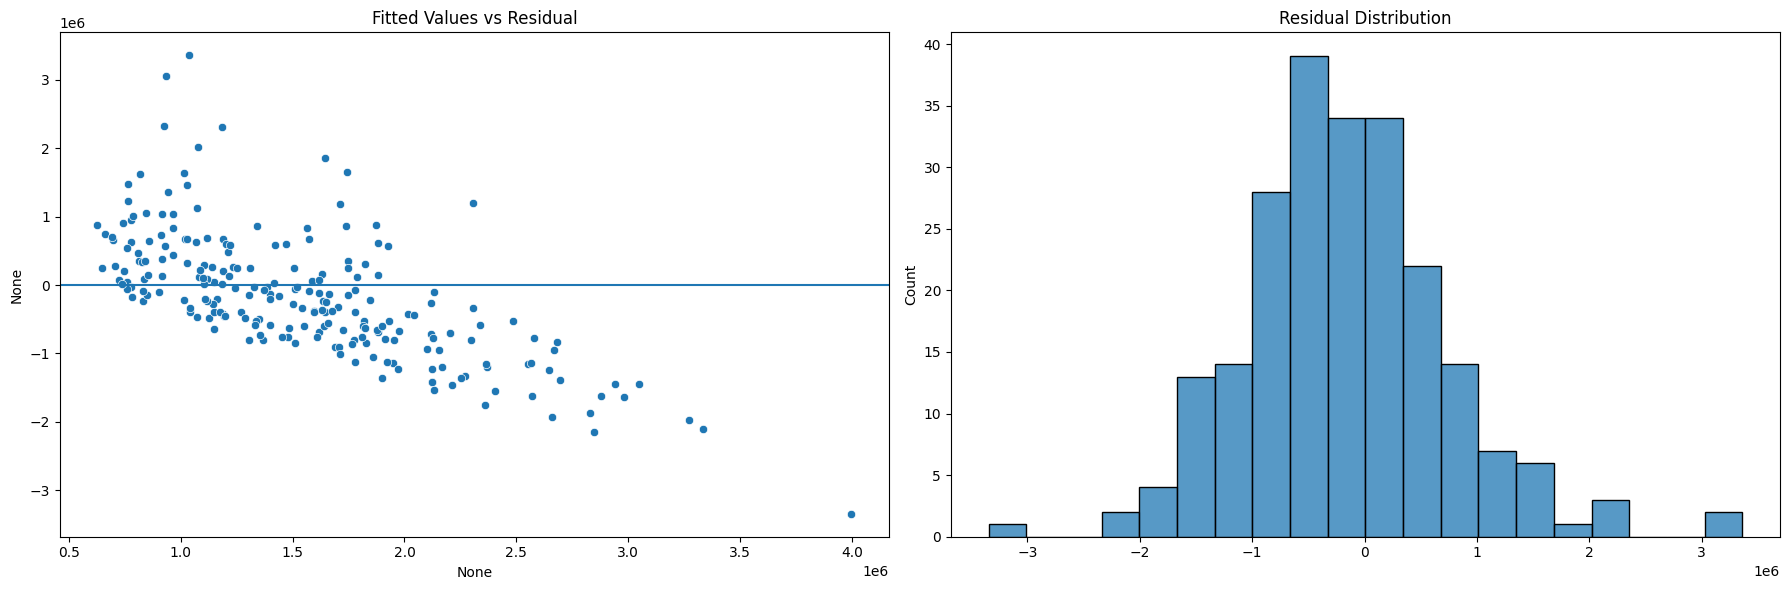

In [35]:
residual = y_test - y_predict_actual

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.scatterplot(x = y_predict_actual,
                y = residual)
plt.axhline(0)
plt.title('Fitted Values vs Residual')

plt.subplot(1,2,2)
sns.histplot(residual)
plt.title('Residual Distribution')

plt.tight_layout()

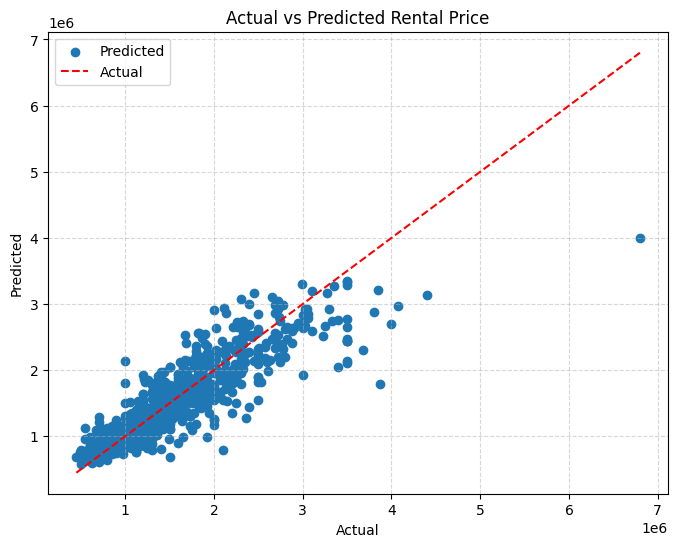

In [36]:
# Plot actual vs prediction in models
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_predict_actual, label="Predicted")

# Reference line y = x
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Actual")


plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Rental Price")
plt.legend()
plt.grid(linestyle="--", alpha=0.5)
plt.show()

### Kesimpulan

Berdasarkan hasil analisis, model regresi yang dikembangkan mampu menjelaskan 78.1% dari variasi harga sewa kos, yang menunjukkan bahwa fitur-fitur yang digunakan memiliki daya prediksi yang sangat kuat. Faktor lokasi terbukti menjadi pendorong harga yang paling signifikan; sebagai contoh, sebuah kos di Jakarta Selatan cenderung memiliki harga 55% lebih tinggi dibandingkan dengan kos di wilayah referensi (Bekasi). Selain lokasi, fasilitas premium juga memainkan peran kunci, di mana keberadaan air panas dapat menaikkan harga sewa sekitar 16%. Di sisi lain, fitur seperti kloset jongkok secara signifikan menurunkan harga sewa sekitar 11.7%.

Secara keseluruhan, model ini mengonfirmasi bahwa harga sewa kos sangat ditentukan oleh kombinasi antara lokasi strategis dan kelengkapan fasilitas modern. Dengan rata-rata kesalahan prediksi (MAE) sekitar Rp 252.000 pada data uji, model ini dapat dianggap sebagai alat yang andal untuk estimasi harga. Keberhasilan ini sangat bergantung pada transformasi logaritma yang telah menstabilkan varians dan memungkinkan interpretasi dampak fitur sebagai perubahan persentase, sehingga memberikan wawasan yang lebih intuitif tentang pendorong utama di pasar sewa kos.